In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy import stats
from scipy.special import boxcox1p

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore") # ignoring annoying warnings

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [7]:
features = pd.read_csv(r'raw_data\features.csv.zip')
train = pd.read_csv(r'raw_data\train.csv.zip')
stores = pd.read_csv(r'raw_data\stores.csv')
test = pd.read_csv(r'raw_data\test.csv.zip')
sample_submission = pd.read_csv(r'raw_data\sampleSubmission.csv.zip')

Exploratory Analysis and Data Cleansing

In this section, we will explore the provided datasets, connect information between some of them and perform relevant transformations. Let's start by merging data from two datasets: features and stores. They have a common key 'Stores'. The data will be loaded into 'feat_sto'.

In [8]:
feat_sto = features.merge(stores, how='inner', on='Store')


In [9]:
feat_sto.head(5)


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [10]:
feat_sto.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
 12  Type          8190 non-null   object 
 13  Size          8190 non-null   int64  
dtypes: bool(1), float64(9), int64(2), object(2)
memory usage: 839.9+ KB


As we can see, the 'Date' fields have string type. We can convert them to datetime and see if the 'train' and 'test' data frames have 'Date' type to convert.

In [11]:
train.head(5)


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [12]:
pd.DataFrame({'Type_Train': train.dtypes, 'Type_Test': test.dtypes})

,Type_Train,Type_Test
Date,object,object
Dept,int64,int64
IsHoliday,bool,bool
Store,int64,int64
Weekly_Sales,float64,NaN


In [13]:
feat_sto.Date = pd.to_datetime(feat_sto.Date)
train.Date = pd.to_datetime(train.Date)
test.Date = pd.to_datetime(test.Date)

In [14]:
feat_sto['Week'] = feat_sto.Date.dt.isocalendar().week
feat_sto['Year'] = feat_sto.Date.dt.year

We can create two new data frames ‘train_detail’ and ‘test_detail’ with all the information we need and join ‘train’ and ‘test’ with ‘feat_sto’. The keys here could be ‘Store’, ‘Dept’ and ‘IsHoliday’.

In [15]:
train_detail = train.merge(feat_sto, 
                           how='inner',
                           on=['Store','Date','IsHoliday']).sort_values(by=['Store',
                                                                            'Dept',
                                                                            'Date']).reset_index(drop=True)

In [16]:
test_detail = test.merge(feat_sto, 
                           how='inner',
                           on=['Store','Date','IsHoliday']).sort_values(by=['Store',
                                                                            'Dept',
                                                                            'Date']).reset_index(drop=True)

In [17]:
del features, train, stores, test

Query missing values

In [18]:
null_columns = (train_detail.isnull().sum(axis = 0)/len(train_detail)).sort_values(ascending=False).index
null_data = pd.concat([
    train_detail.isnull().sum(axis = 0),
    (train_detail.isnull().sum(axis = 0)/len(train_detail)).sort_values(ascending=False),
    train_detail.loc[:, train_detail.columns.isin(list(null_columns))].dtypes], axis=1)
null_data = null_data.rename(columns={0: '# null', 
                                      1: '% null', 
                                      2: 'type'}).sort_values(ascending=False, by = '% null')
null_data = null_data[null_data["# null"]!=0]
null_data

,# null,% null,type
MarkDown2,310322,0.736110,float64
MarkDown4,286603,0.679847,float64
MarkDown3,284479,0.674808,float64
MarkDown1,270889,0.642572,float64
MarkDown5,270138,0.640790,float64


This is important to note because some of the columns have more than 60% null values. If these features have a ~0 correlation with the target “WeeklySales”, then it is not a good idea to use them. Also, they are anonymous fields and it is hard to know what they mean.

Holiday Analysis

Here, we will analyze the weekdays that holidays fall on for each year. This is related to knowing how many days before the holiday there are in each week marked as “True” in the “ishholiday” field. If one year has more days before the holiday than another year in a certain week, then the year with more days before the holiday is likely to have greater sales in the same week. Therefore, the model will not take this into account and we may need to adjust the predictions at the end. Another thing to consider is that if there are few or no days before the holiday, then the holiday week may have lower sales than the previous week.

Using SQL, we can put the week of each holiday into each year. According to research, Super Bowl, Labor Day, and Thanksgiving are on the same day. On the other hand, Christmas is always on December 25th, so the weekday can change.

In [19]:
pysqldf("""
SELECT
    T.*,
    case
        when ROW_NUMBER() OVER(partition by Year order by week) = 1 then 'Super Bowl'
        when ROW_NUMBER() OVER(partition by Year order by week) = 2 then 'Labor Day'
        when ROW_NUMBER() OVER(partition by Year order by week) = 3 then 'Thanksgiving'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 then 'Christmas'
    end as Holyday,
    case
        when ROW_NUMBER() OVER(partition by Year order by week) = 1 then 'Sunday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 2 then 'Monday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 3 then 'Thursday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 and Year = 2010 then 'Saturday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 and Year = 2011 then 'Sunday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 and Year = 2012 then 'Tuesday'
    end as Day
    from(
        SELECT DISTINCT
            Year,
            Week,
            case 
                when Date <= '2012-11-01' then 'Train Data' else 'Test Data' 
            end as Data_type
        FROM feat_sto
        WHERE IsHoliday = True) as T""")

,Year,Week,Data_type,Holyday,Day
0,2010,6,Train Data,Super Bowl,Sunday
1,2010,36,Train Data,Labor Day,Monday
2,2010,47,Train Data,Thanksgiving,Thursday
3,2010,52,Train Data,Christmas,Saturday
4,2011,6,Train Data,Super Bowl,Sunday
5,2011,36,Train Data,Labor Day,Monday
6,2011,47,Train Data,Thanksgiving,Thursday
7,2011,52,Train Data,Christmas,Sunday
8,2012,6,Train Data,Super Bowl,Sunday
9,2012,36,Train Data,Labor Day,Monday


Some interesting notes about the results:

All holidays are in the same week

Test Data does not have Labor Day, so this holiday is not very relevant

There were 0 days before Christmas in 2010, 1 day in 2011, and 3 days in 2012.

The model will not take into account the additional Sales in 2012 for Test Data, so we will adjust it at the end and give the formula and explanation.

Let's look at the average weekly sales for each year and find out if there are other holiday sales spikes not accounted for by the "isholay" field.

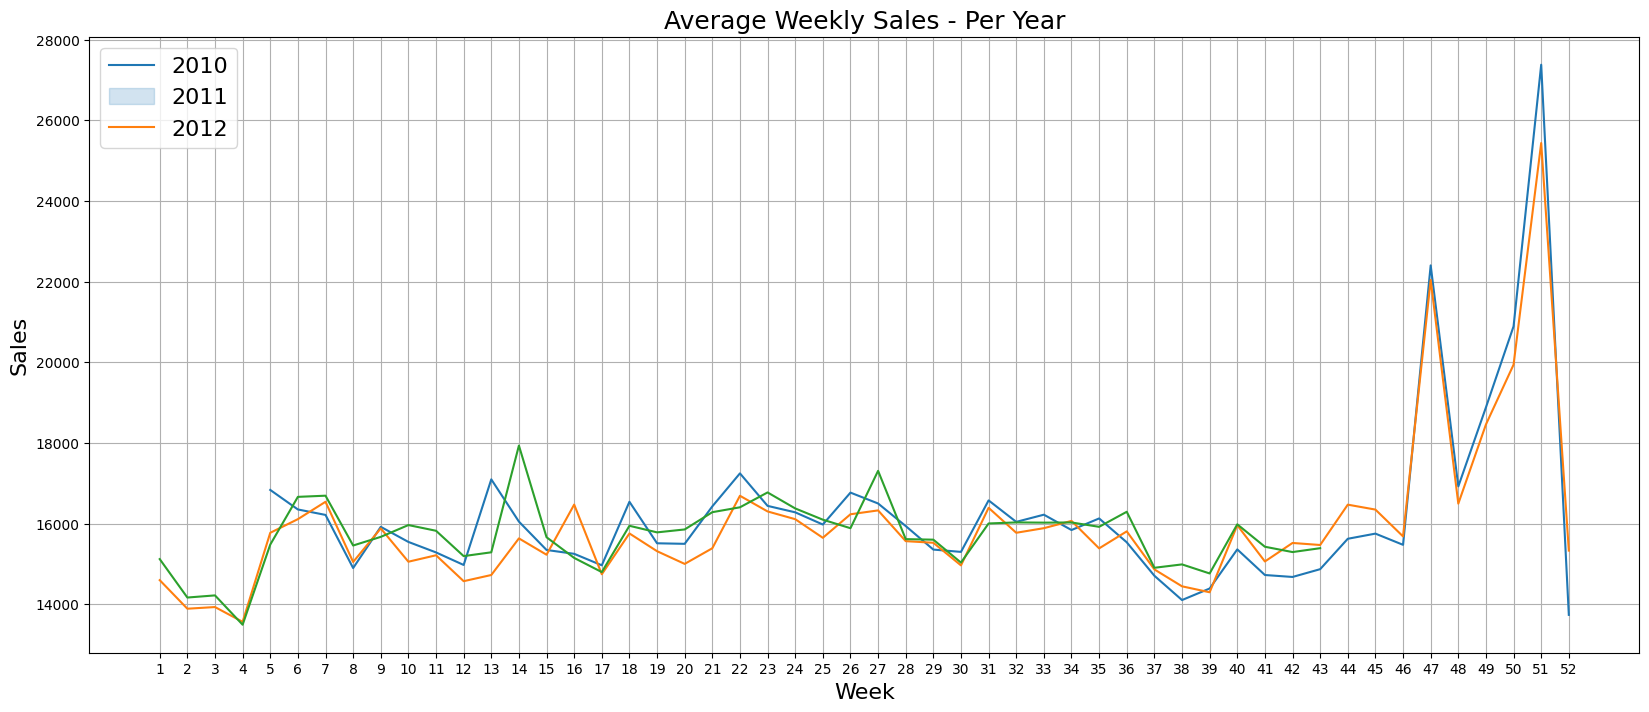

In [20]:
weekly_sales_2010 = train_detail[train_detail.Year==2010]['Weekly_Sales'].groupby(train_detail['Week']).mean()
weekly_sales_2011 = train_detail[train_detail.Year==2011]['Weekly_Sales'].groupby(train_detail['Week']).mean()
weekly_sales_2012 = train_detail[train_detail.Year==2012]['Weekly_Sales'].groupby(train_detail['Week']).mean()
plt.figure(figsize=(20,8))
sns.lineplot(x=weekly_sales_2010.index, y=weekly_sales_2010.values)
sns.lineplot(x=weekly_sales_2011.index, y=weekly_sales_2011.values)
sns.lineplot(x=weekly_sales_2012.index, y=weekly_sales_2012.values)
plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)
plt.title('Average Weekly Sales - Per Year', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Week', fontsize=16)
plt.show()

As we can see, there is one important holiday that is not included in "My Holidays". Today is Easter. It is always on a Sunday, but can fall on different weeks.

2010 in week 13

2011, week 16

2012 week 14

Finally, the test set for week 13 in 2013

So we can change to "True" for these weeks of each year. >

In [21]:
train_detail.loc[(train_detail.Year==2010) & (train_detail.Week==13), 'IsHoliday'] = True
train_detail.loc[(train_detail.Year==2011) & (train_detail.Week==16), 'IsHoliday'] = True
train_detail.loc[(train_detail.Year==2012) & (train_detail.Week==14), 'IsHoliday'] = True
test_detail.loc[(test_detail.Year==2013) & (test_detail.Week==13), 'IsHoliday'] = True

The same chart, but also showing the median sales, without dividing by year:

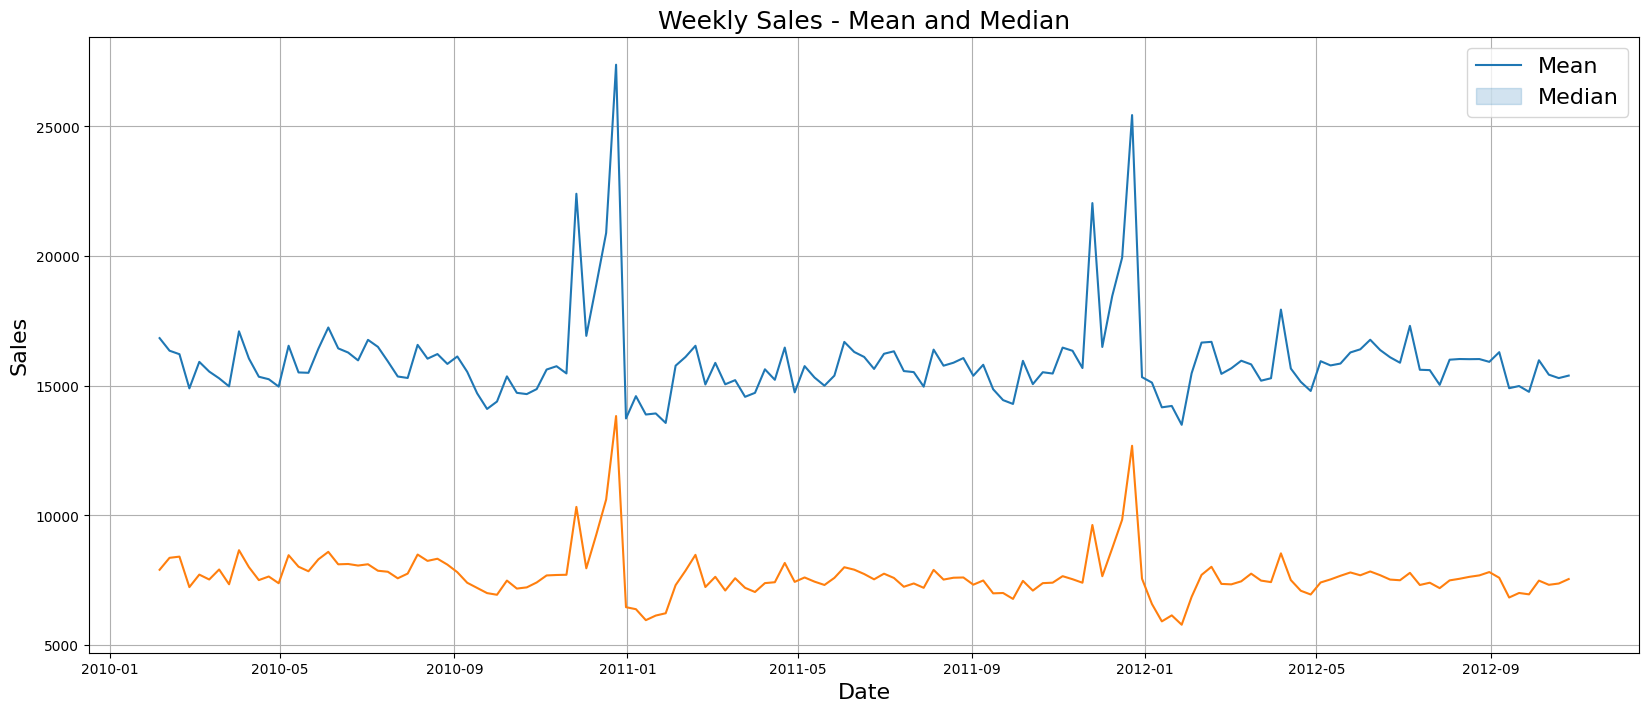

In [22]:
weekly_sales_mean = train_detail['Weekly_Sales'].groupby(train_detail['Date']).mean()
weekly_sales_median = train_detail['Weekly_Sales'].groupby(train_detail['Date']).median()
plt.figure(figsize=(20,8))
sns.lineplot(x=weekly_sales_mean.index, y=weekly_sales_mean.values)
sns.lineplot(x=weekly_sales_median.index, y=weekly_sales_median.values)
plt.grid()
plt.legend(['Mean', 'Median'], loc='best', fontsize=16)
plt.title('Weekly Sales - Mean and Median', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.show()

As you can see, the mean and median are very different, which indicates that some stores/departments may be selling more than others.

Average sales per store and department

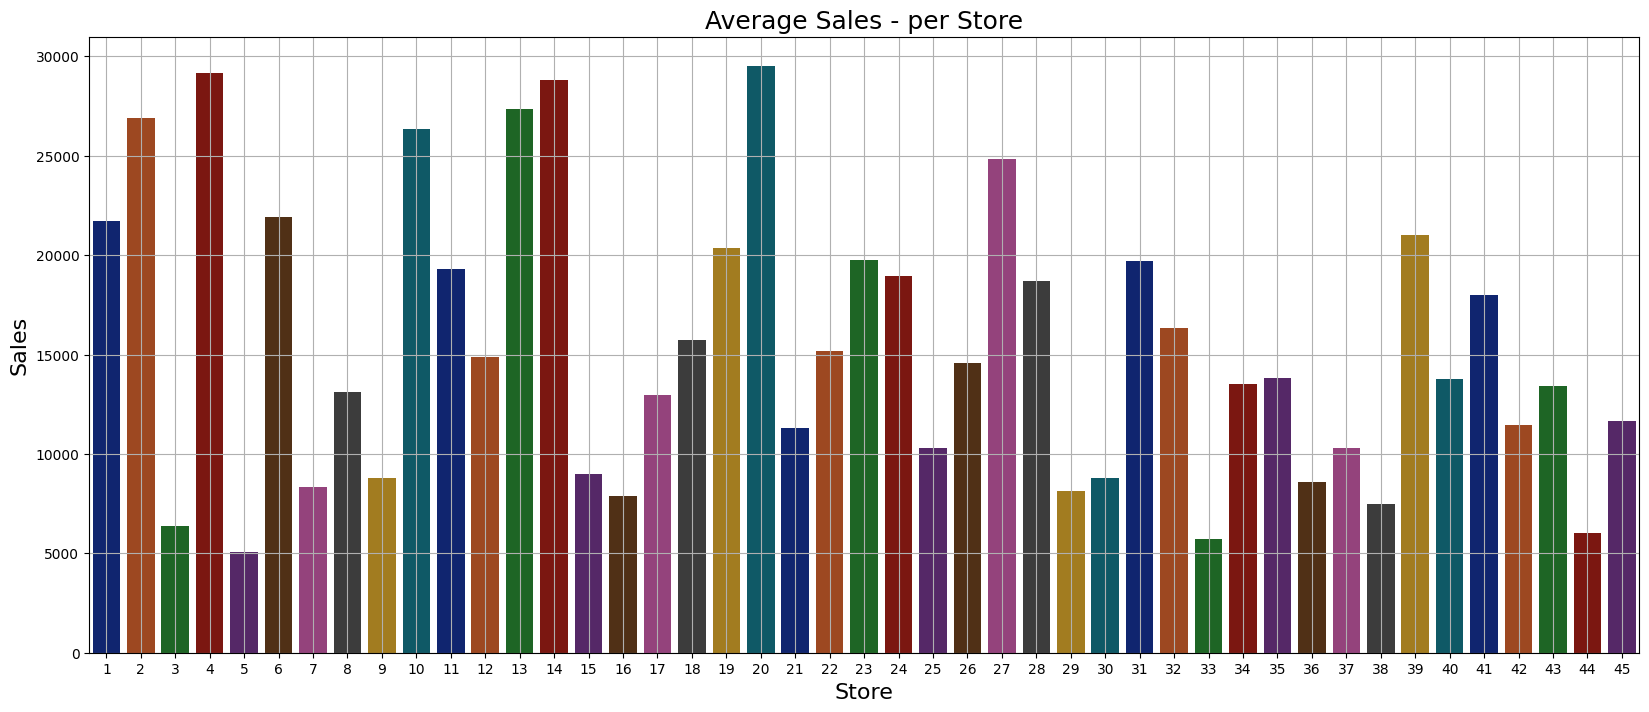

In [23]:
weekly_sales = train_detail['Weekly_Sales'].groupby(train_detail['Store']).mean()
plt.figure(figsize=(20,8))
sns.barplot(x=weekly_sales.index, y=weekly_sales.values, palette='dark')
plt.grid()
plt.title('Average Sales - per Store', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.show()

Yes, there are sales differences between stores.

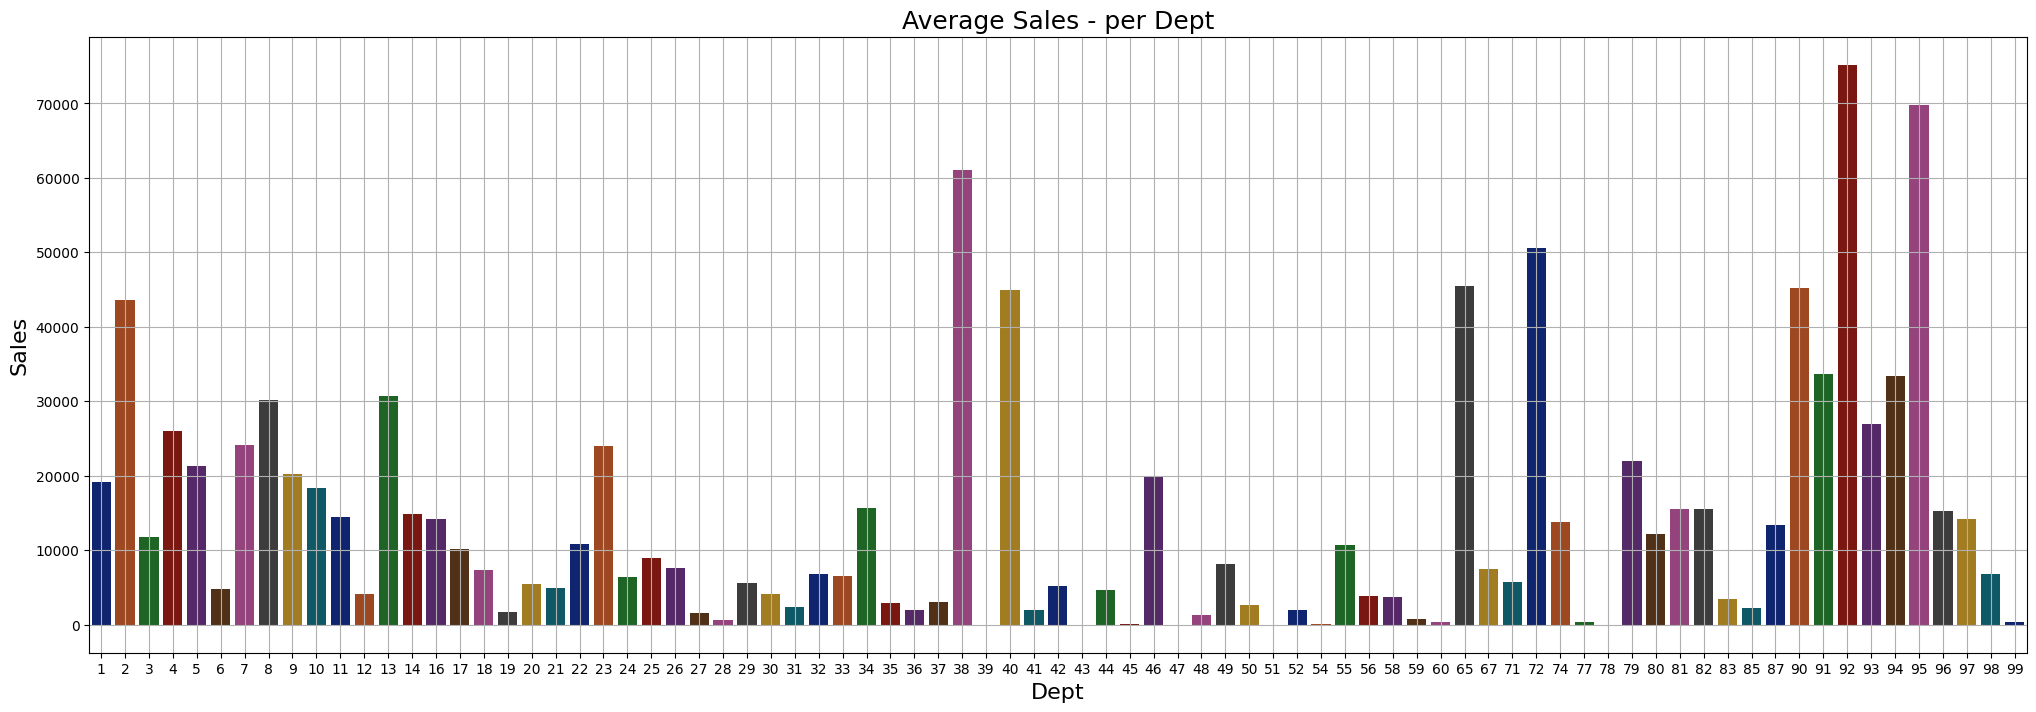

In [24]:
weekly_sales = train_detail['Weekly_Sales'].groupby(train_detail['Dept']).mean()
plt.figure(figsize=(25,8))
sns.barplot(x=weekly_sales.index, y=weekly_sales.values, palette='dark')
plt.grid()
plt.title('Average Sales - per Dept', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Dept', fontsize=16)
plt.show()

There are also sales differences between departments. There are also some departments that are not in the list, such as "15".

**Correlation of variables**

Let's look at the correlation between variables, using Pearson correlation.

Correlation index:

0: Not correlated at all

0-0.3: Weak correlation

0.3-0.7: Moderate correlation

0.7-1: Strong correlation

Positive correlation indicates that when one variable increases, the other variable also increases. Negative is the opposite.

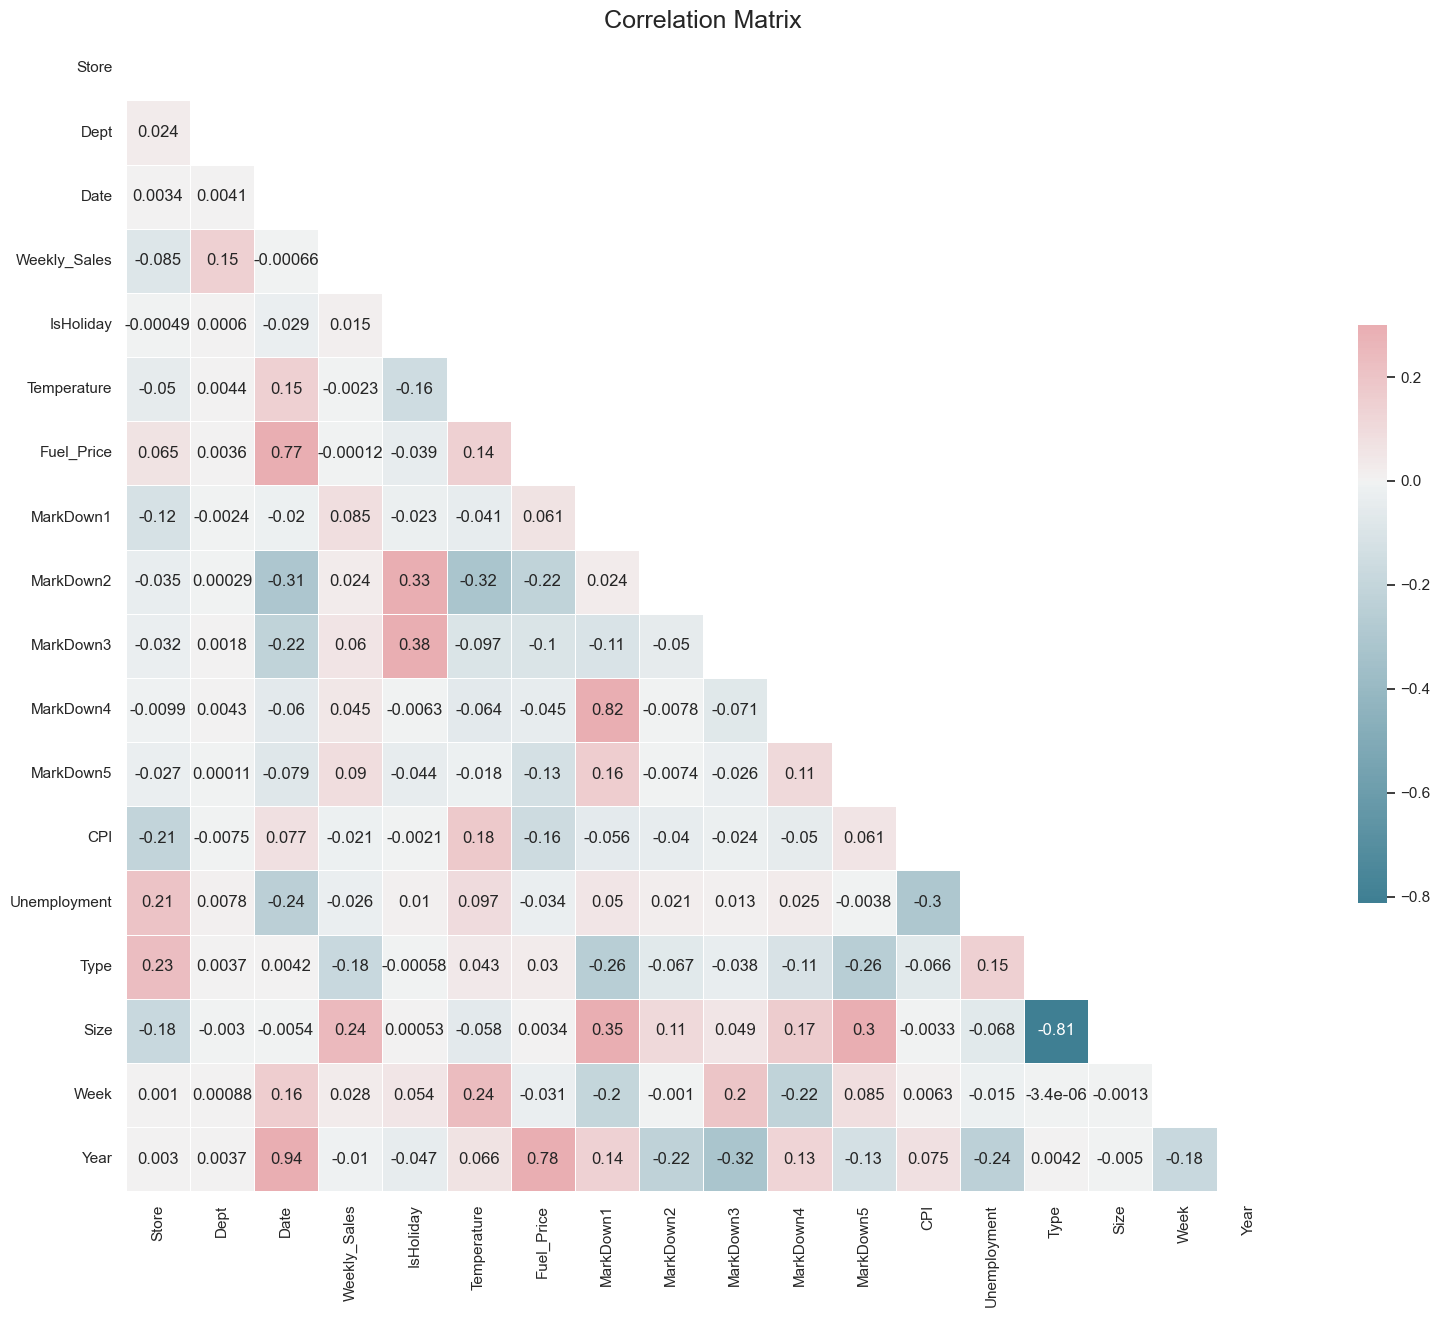

In [25]:
from sklearn.preprocessing import LabelEncoder

# Encode object type columns
le = LabelEncoder()
train_encoded = train_detail.apply(lambda x: le.fit_transform(x) if x.dtype == 'object' else x)
corr = train_encoded.corr()

sns.set(style="white")

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(20, 15))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.title('Correlation Matrix', fontsize=18)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

‘MarkDown’ 1 to 5 are not strongly correlated with ‘Weekly_Sales’, they have a lot of null values, then we can remove them.

Also, ‘Fuel_Price’ is strongly correlated with ‘Year’. One of them must be dropped, otherwise they will carry similar information to the model. ‘Year’ will not be dropped because it distinguishes the same week for ‘Store’ + ‘Dept’.

Other variables that are less correlated with ‘Weekly_Sales’ can be analyzed to see if they are useful.

In [26]:
train_detail = train_detail.drop(columns=['Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])
test_detail = test_detail.drop(columns=['Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])

Variable Analysis

First, there are two plotting functions that can help us.

Discrete plots are for limited numbers. We will use box plots to see the median and interquartile range, while strip plots are a better way to see the distribution, especially when there are a lot of outliers.

Continuous plots, as the name suggests, are for continuous variables. We will see the distribution of probabilities and use BoxCox to see if the correlation of each variable increases and the skewness decreases. In some cases, depending on the model, the process of transforming the variables may help.

In [27]:
def make_discrete_plot(feature):
    fig = plt.figure(figsize=(20,8))
    gs = GridSpec(1,2)
    sns.boxplot(y=train_detail.Weekly_Sales, x=train_detail[feature], ax=fig.add_subplot(gs[0,0]))
    plt.ylabel('Sales', fontsize=16)
    plt.xlabel(feature, fontsize=16)
    sns.stripplot(y=train_detail.Weekly_Sales, x=train_detail[feature], ax=fig.add_subplot(gs[0,1]))
    plt.ylabel('Sales', fontsize=16)
    plt.xlabel(feature, fontsize=16)
    fig.show()

In [28]:
def make_continuous_plot(feature):
    
    fig = plt.figure(figsize=(18,15))
    gs = GridSpec(2,2)
    
    j = sns.scatterplot(y=train_detail['Weekly_Sales'], 
                        x=boxcox1p(train_detail[feature], 0.15), ax=fig.add_subplot(gs[0,1]), palette = 'blue')

    plt.title('BoxCox 0.15\n' + 'Corr: ' + str(np.round(train_detail['Weekly_Sales'].corr(boxcox1p(train_detail[feature], 0.15)),2)) +
              ', Skew: ' + str(np.round(stats.skew(boxcox1p(train_detail[feature], 0.15), nan_policy='omit'),2)))
    
    j = sns.scatterplot(y=train_detail['Weekly_Sales'], 
                        x=boxcox1p(train_detail[feature], 0.25), ax=fig.add_subplot(gs[1,0]), palette = 'blue')

    plt.title('BoxCox 0.25\n' + 'Corr: ' + str(np.round(train_detail['Weekly_Sales'].corr(boxcox1p(train_detail[feature], 0.25)),2)) +
              ', Skew: ' + str(np.round(stats.skew(boxcox1p(train_detail[feature], 0.25), nan_policy='omit'),2)))
    
    j = sns.distplot(train_detail[feature], ax=fig.add_subplot(gs[1,1]), color = 'green')

    plt.title('Distribution\n')
    
    j = sns.scatterplot(y=train_detail['Weekly_Sales'], 
                        x=train_detail[feature], ax=fig.add_subplot(gs[0,0]), color = 'red')

    plt.title('Linear\n' + 'Corr: ' + str(np.round(train_detail['Weekly_Sales'].corr(train_detail[feature]),2)) + ', Skew: ' + 
               str(np.round(stats.skew(train_detail[feature], nan_policy='omit'),2)))
    
    fig.show()

Weekly_Sales x Type

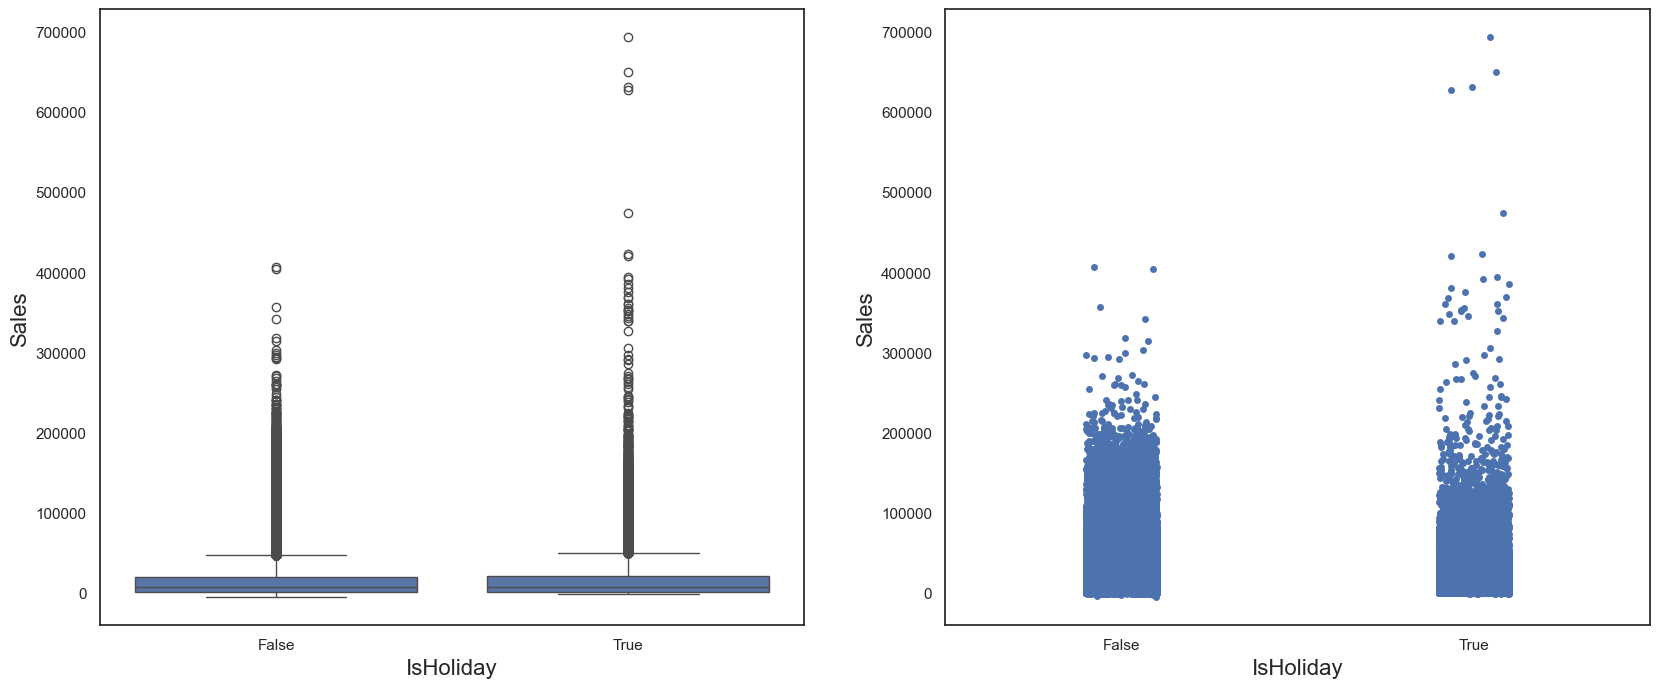

In [29]:
make_discrete_plot('IsHoliday')

This field is very important to distinguish holidays. As we can see, holidays have more high sales events than non-holidays.

Weekly_Sales x IsHoliday



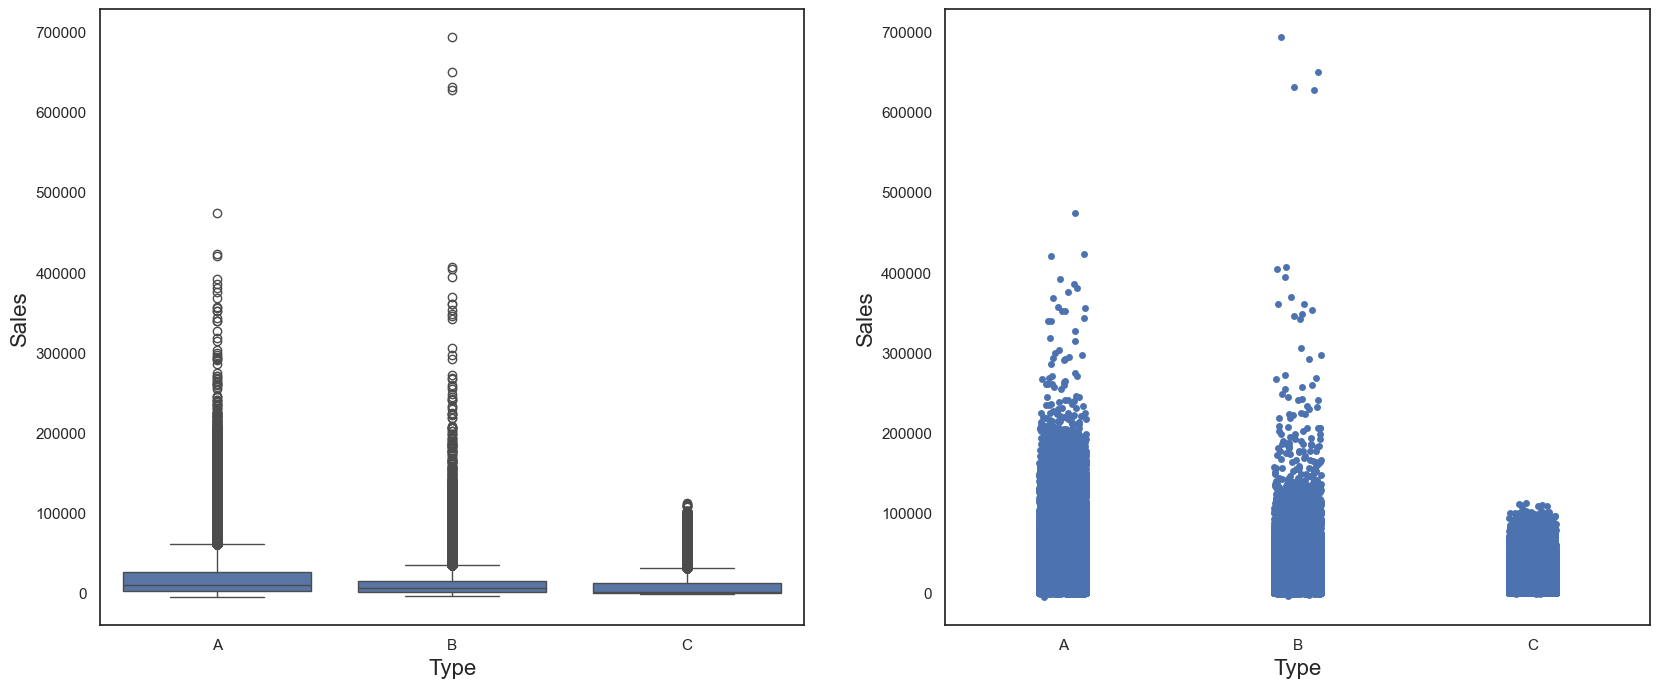

In [30]:
make_discrete_plot('Type')

We don't know what "type" is, but we can assume that A>B>C is the median sales. We treat it as an ordinal variable and replace its values. The ordinal variable looks like the following figure.

In [31]:
train_detail.Type = train_detail.Type.apply(lambda x: 3 if x == 'A' else(2 if x == 'B' else 1))
test_detail.Type = test_detail.Type.apply(lambda x: 3 if x == 'A' else(2 if x == 'B' else 1))

Weekly_Sales x Temperature

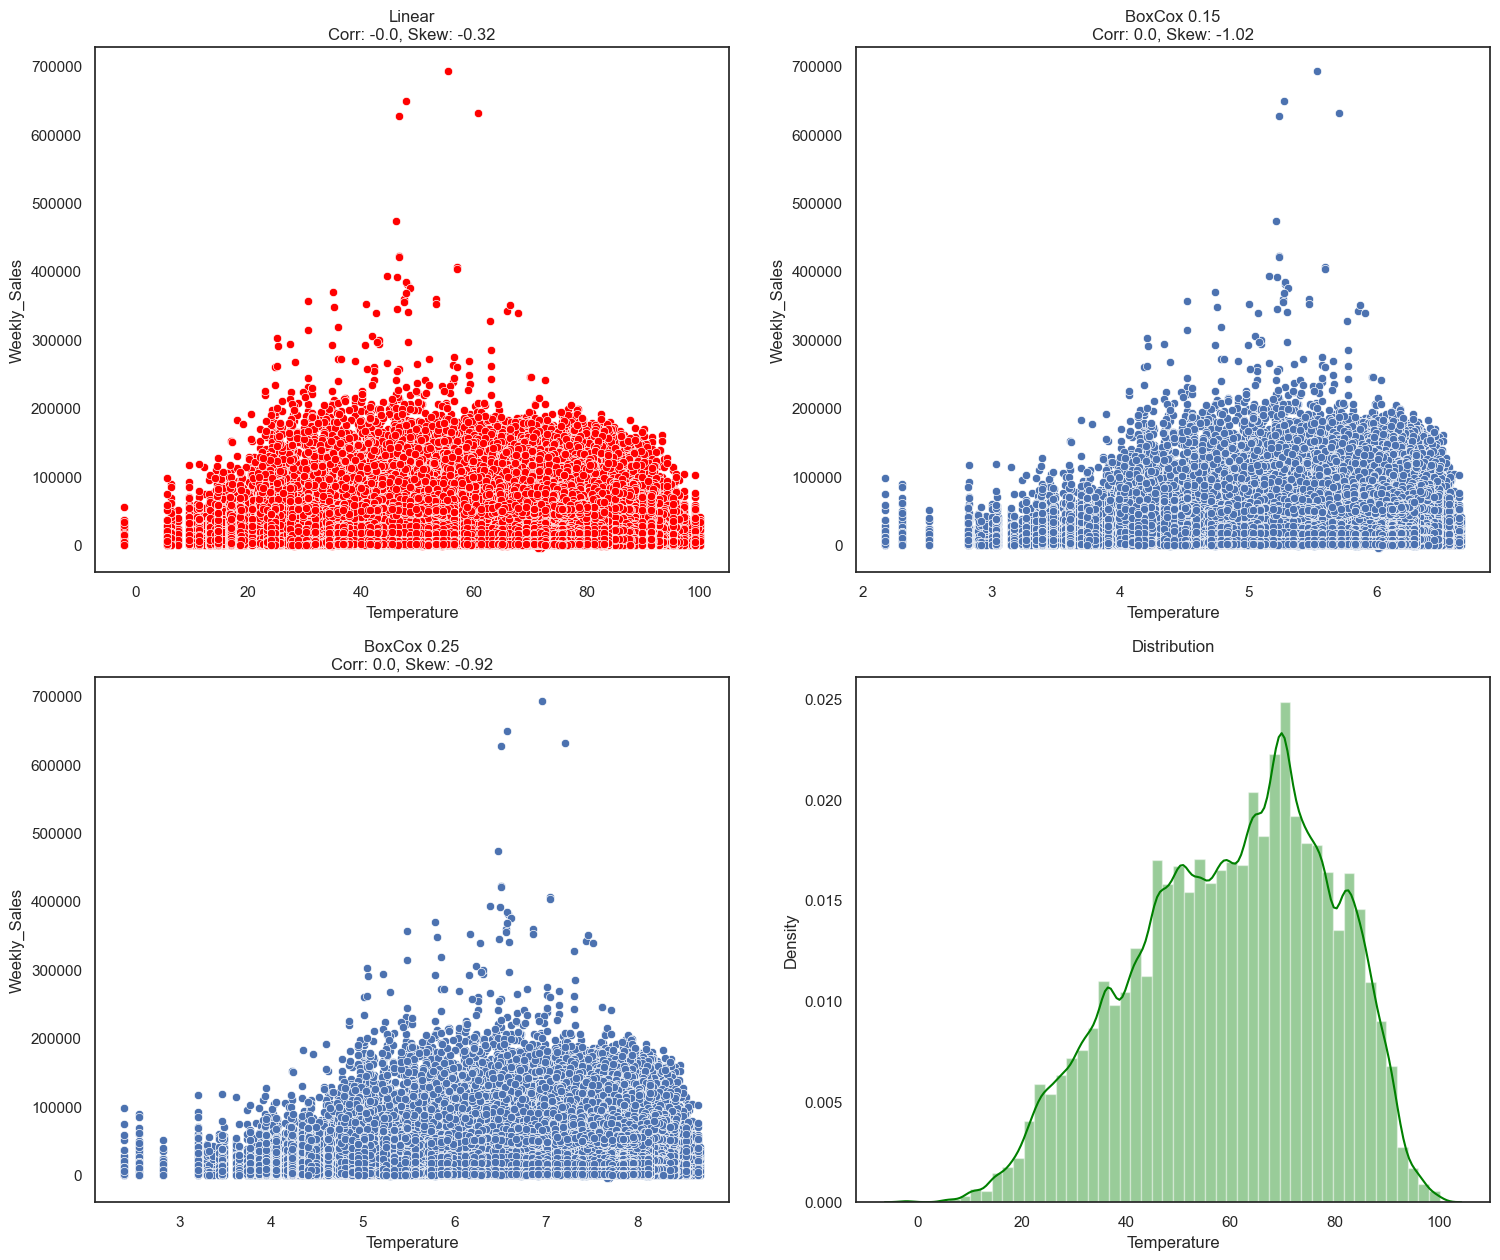

In [32]:
make_continuous_plot('Temperature')

Despite the change in skewness, the correlation does not seem to have changed at all. We can decide to discard it.

In [33]:
train_detail = train_detail.drop(columns=['Temperature'])
test_detail = test_detail.drop(columns=['Temperature'])

Weekly_Sales x CPI

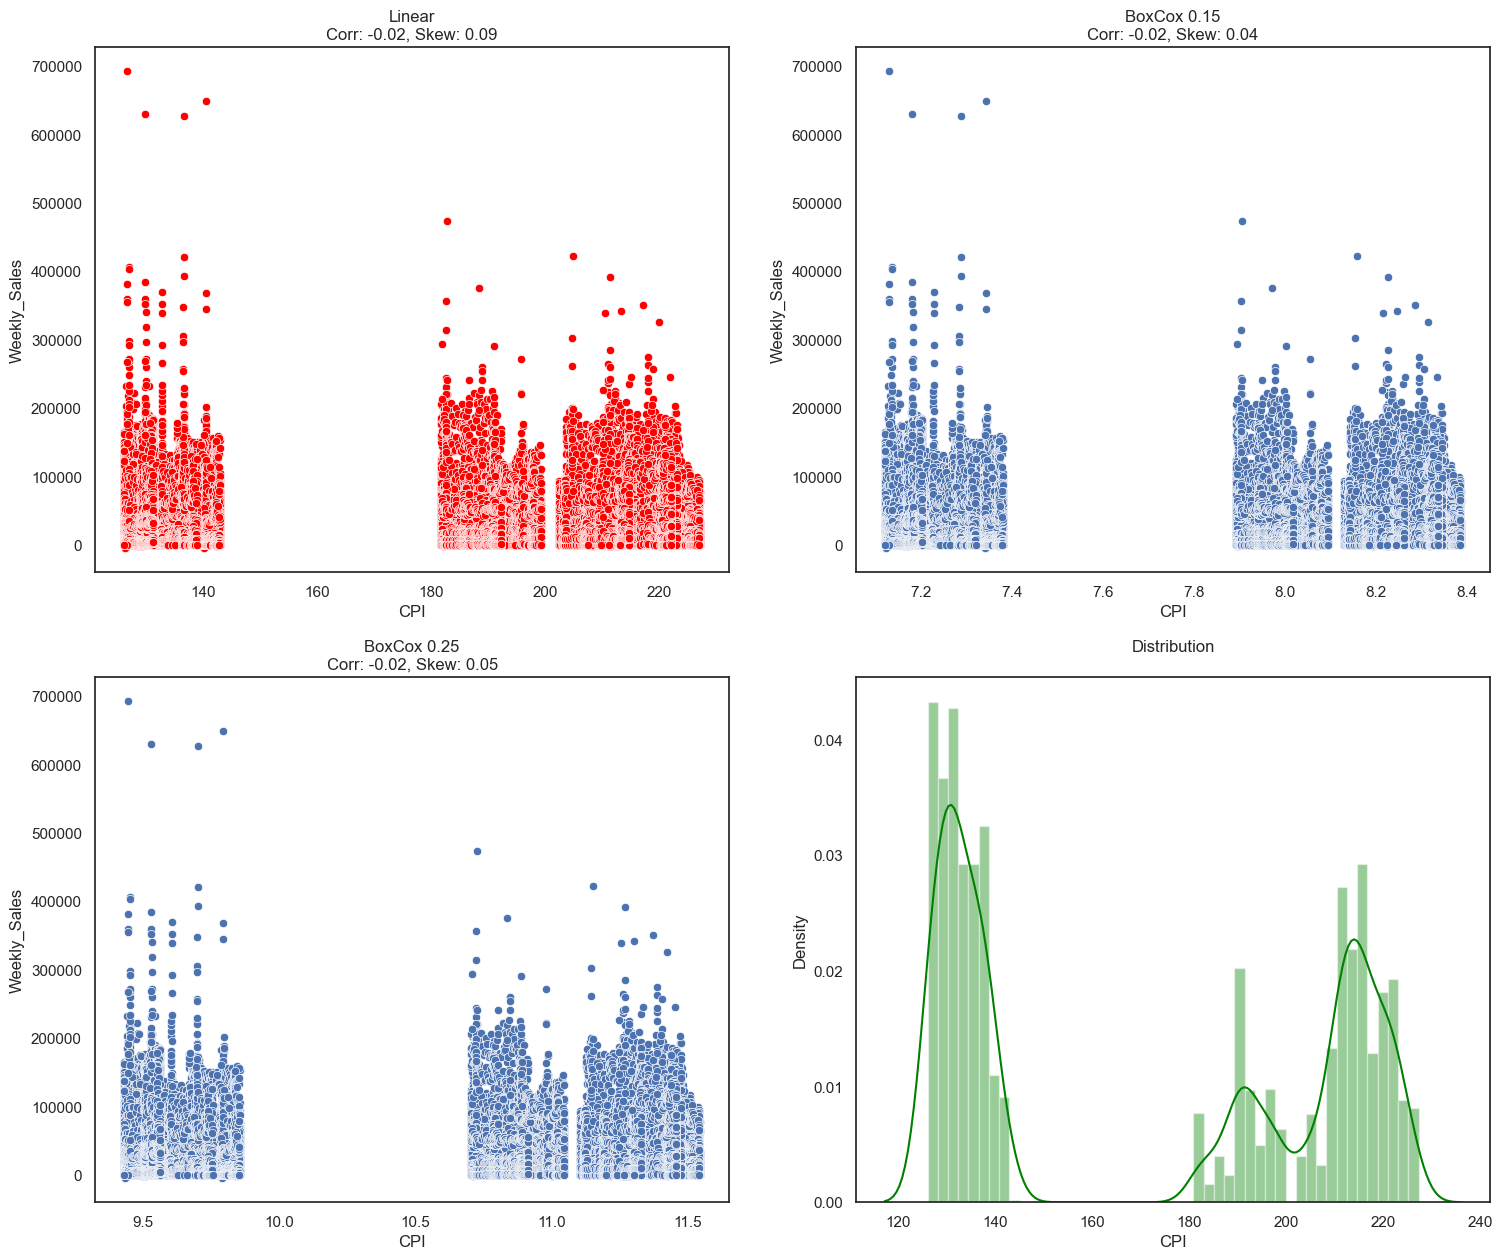

In [34]:
make_continuous_plot('CPI')

In [35]:
train_detail = train_detail.drop(columns=['CPI'])
test_detail = test_detail.drop(columns=['CPI'])

Weekly_Sales x Unemployment

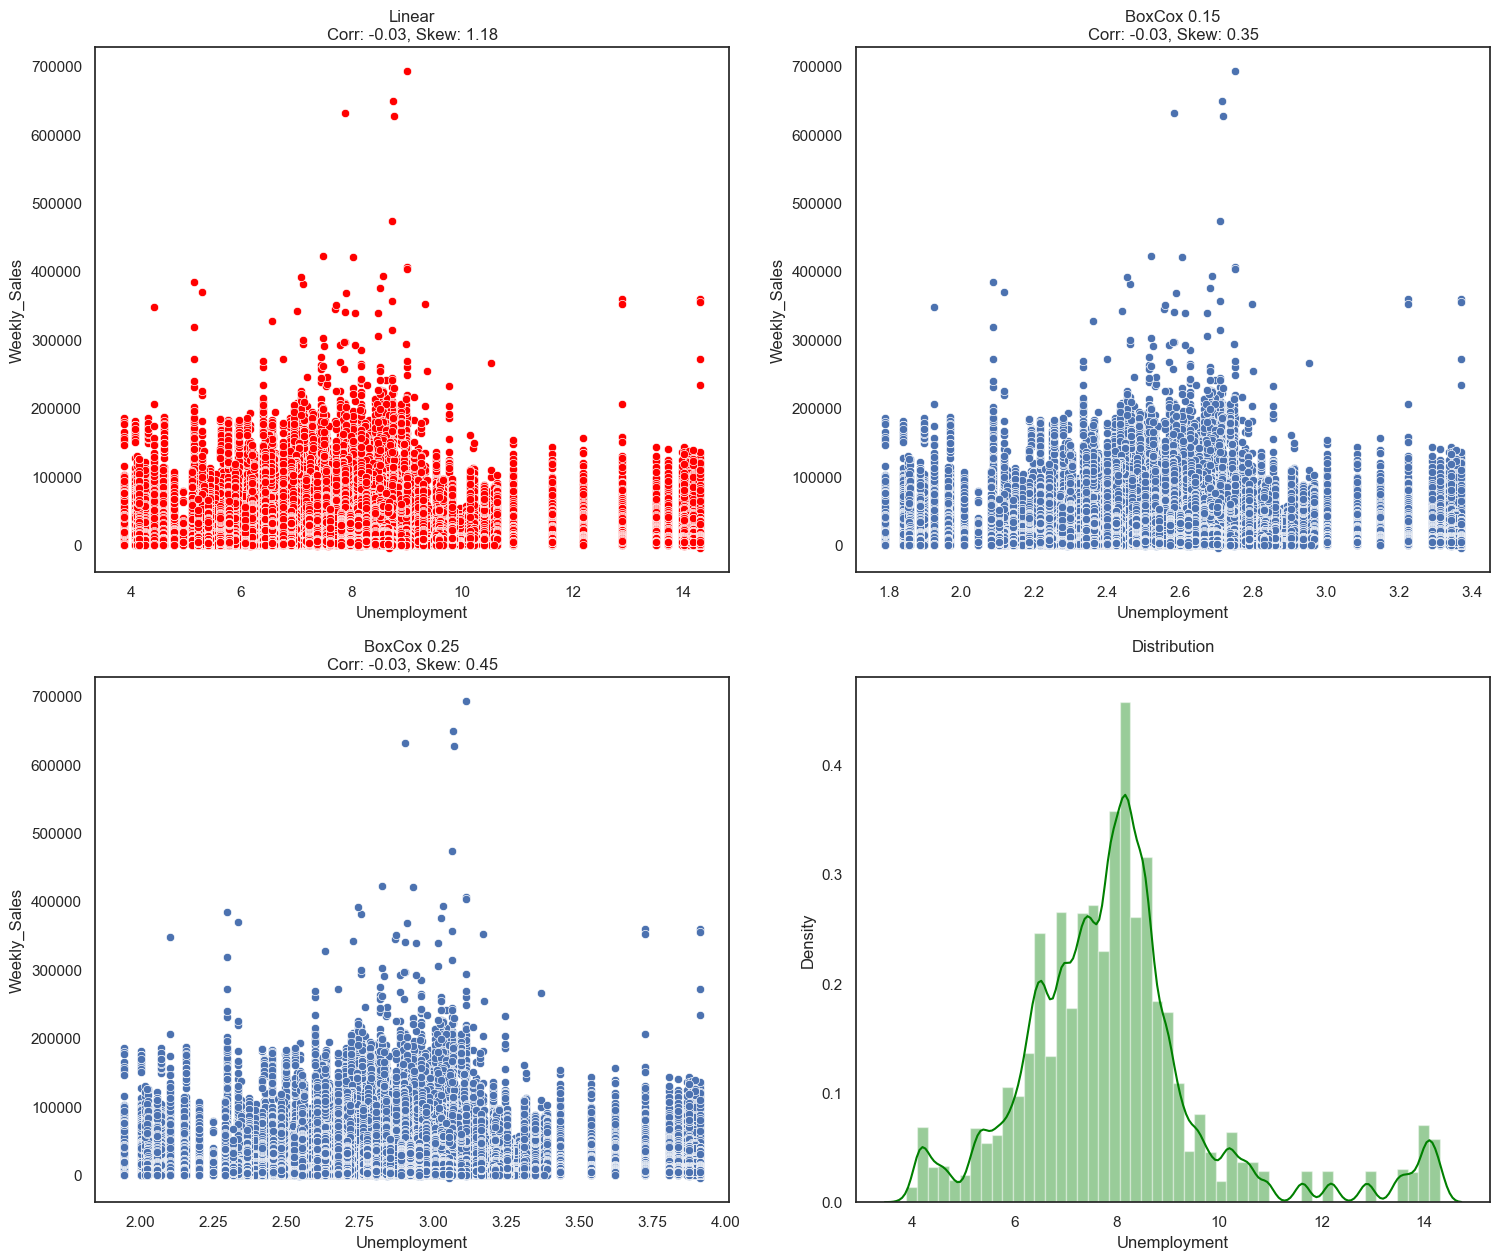

In [36]:
make_continuous_plot('Unemployment')

In [37]:
train_detail = train_detail.drop(columns=['Unemployment'])
test_detail = test_detail.drop(columns=['Unemployment'])

Weekly_Sales x Size

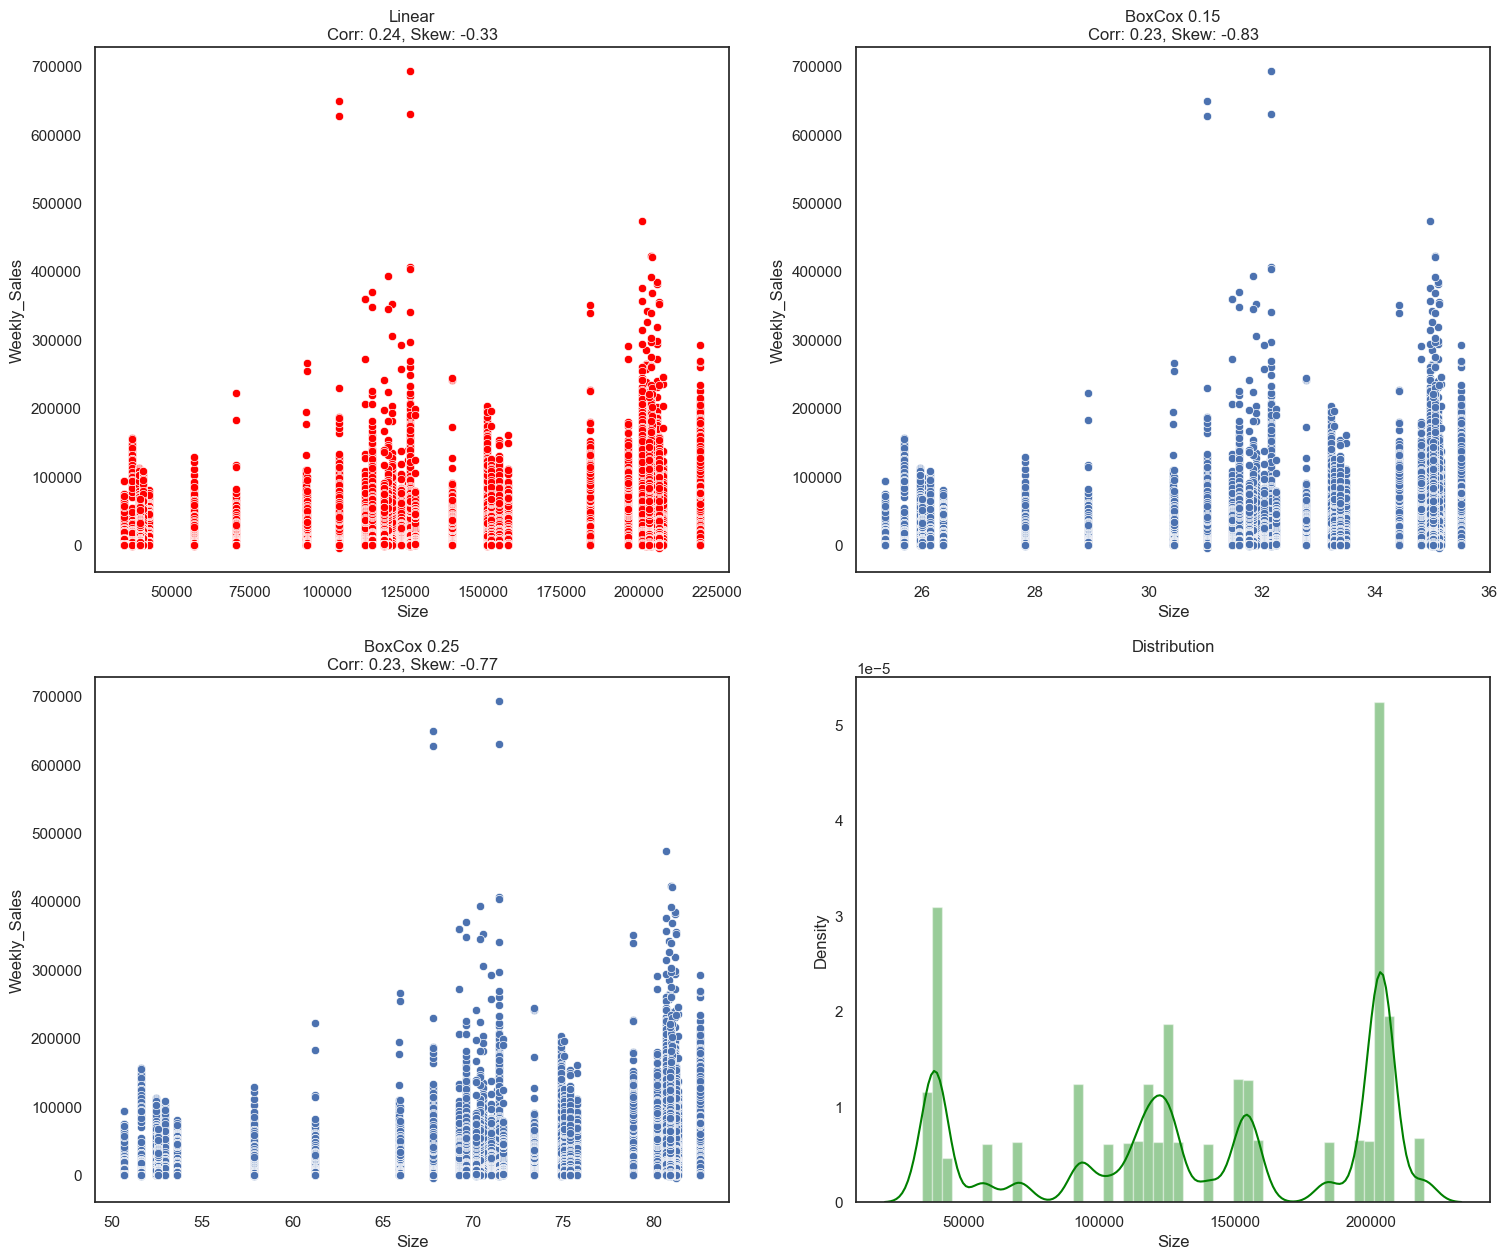

In [38]:
make_continuous_plot('Size')

Finally, we will continue to use this variable because it is moderately correlated with WeeklySales.

## Machine Learning

As shown in the figure below, the evaluation is based on the weighted mean absolute error (WMAE), with holiday weeks having a weight of 5 and other times having a weight of 1.

$$
WMAE = \frac{\sum_{i=1}^{n} w_i |y_i - \hat{y}_i|}{\sum_{i=1}^{n} w_i}
$$

$$
w_i =
\begin{cases} 
5, & \text{if the week is a holiday week} \\
1, & \text{otherwise}
\end{cases}
$$


So, let’s turn the formula into a function, since we can’t use GridSearchCV or RandomSearchCV:

In [39]:
def WMAE(dataset, real, predicted):
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)

The model chosen for this project is Random Forest Regression. It is an ensemble method that uses multiple decision trees (‘n_estimators’ parameter of the model) to determine the final output, which is the average of all the tree outputs.

The algorithm selects a feature as the root node and splits the sample. We can choose the function to measure the quality of the split and pass it as a parameter. The split will continue until the number of samples of the internal node is less than ‘min_samples_split’, then it splits and becomes a leaf node. ‘min_samples_leaf’ tells the minimum number of samples to be considered as a leaf node. There is also an important parameter called ‘max_features’ which is the maximum number of features that are considered when a node needs to be optimally split. The number of layers is the ‘max_depth’ parameter.

It is important to tune these parameters to find the best predictor and minimize overfitting.

The functions for random forest, parameter tuning, and cross validation are:

In [40]:
def random_forest(n_estimators, max_depth):
    result = []
    for estimator in n_estimators:
        for depth in max_depth:
            wmaes_cv = []
            for i in range(1,5):
                print('k:', i, ', n_estimators:', estimator, ', max_depth:', depth)
                x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
                RF = RandomForestRegressor(n_estimators=estimator, max_depth=depth)
                RF.fit(x_train, y_train)
                predicted = RF.predict(x_test)
                wmaes_cv.append(WMAE(x_test, y_test, predicted))
            print('WMAE:', np.mean(wmaes_cv))
            result.append({'Max_Depth': depth, 'Estimators': estimator, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

In [44]:
def random_forest_2(n_estimators, max_depth, max_features):
    result = []
    for feature in max_features:
        wmaes_cv = []
        for i in range(1,5):
            print('k:', i, ', max_features:', feature)
            x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
            RF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=feature)
            RF.fit(x_train, y_train)
            predicted = RF.predict(x_test)
            wmaes_cv.append(WMAE(x_test, y_test, predicted))
        print('WMAE:', np.mean(wmaes_cv))
        result.append({'Max_Feature': feature, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

In [45]:
def random_forest_3(n_estimators, max_depth, max_features, min_samples_split, min_samples_leaf):
    result = []
    for split in min_samples_split:
        for leaf in min_samples_leaf:
            wmaes_cv = []
            for i in range(1,5):
                print('k:', i, ', min_samples_split:', split, ', min_samples_leaf:', leaf)
                x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
                RF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features, 
                                           min_samples_leaf=leaf, min_samples_split=split)
                RF.fit(x_train, y_train)
                predicted = RF.predict(x_test)
                wmaes_cv.append(WMAE(x_test, y_test, predicted))
            print('WMAE:', np.mean(wmaes_cv))
            result.append({'Min_Samples_Leaf': leaf, 'Min_Samples_Split': split, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

Training the model

In [43]:
X_train = train_detail[['Store','Dept','IsHoliday','Size','Week','Type','Year']]
Y_train = train_detail['Weekly_Sales']

Adjust 'n_estimators' and 'max_depth'.

There are a lot of values ​​that can be tested here. These are the final versions after some testing.

In [46]:
n_estimators = [56, 58, 60]
max_depth = [25, 27, 30]

random_forest(n_estimators, max_depth)

k: 1 , n_estimators: 56 , max_depth: 25
k: 2 , n_estimators: 56 , max_depth: 25
k: 3 , n_estimators: 56 , max_depth: 25
k: 4 , n_estimators: 56 , max_depth: 25
WMAE: 1542.4975000000002
k: 1 , n_estimators: 56 , max_depth: 27
k: 2 , n_estimators: 56 , max_depth: 27
k: 3 , n_estimators: 56 , max_depth: 27
k: 4 , n_estimators: 56 , max_depth: 27
WMAE: 1531.2725
k: 1 , n_estimators: 56 , max_depth: 30
k: 2 , n_estimators: 56 , max_depth: 30
k: 3 , n_estimators: 56 , max_depth: 30
k: 4 , n_estimators: 56 , max_depth: 30
WMAE: 1542.935
k: 1 , n_estimators: 58 , max_depth: 25
k: 2 , n_estimators: 58 , max_depth: 25
k: 3 , n_estimators: 58 , max_depth: 25
k: 4 , n_estimators: 58 , max_depth: 25
WMAE: 1544.46
k: 1 , n_estimators: 58 , max_depth: 27
k: 2 , n_estimators: 58 , max_depth: 27
k: 3 , n_estimators: 58 , max_depth: 27
k: 4 , n_estimators: 58 , max_depth: 27
WMAE: 1551.4599999999998
k: 1 , n_estimators: 58 , max_depth: 30
k: 2 , n_estimators: 58 , max_depth: 30
k: 3 , n_estimators: 58 ,

,Max_Depth,Estimators,WMAE
0,25,56,1542.4975
1,27,56,1531.2725
2,30,56,1542.9350
3,25,58,1544.4600
4,27,58,1551.4600
5,30,58,1550.4075
6,25,60,1545.1275
7,27,60,1547.1100
8,30,60,1541.2125


The results I ran were 58 and 27.

Optimize "max_features".

In [ ]:
max_features = [2, 3, 4, 5, 6, 7]

random_forest_2(n_estimators=58, max_depth=27, max_features=max_features)

k: 1 , max_features: 2
k: 2 , max_features: 2
k: 3 , max_features: 2
k: 4 , max_features: 2
WMAE: 4555.095
k: 1 , max_features: 3
k: 2 , max_features: 3
k: 3 , max_features: 3
k: 4 , max_features: 3
WMAE: 2630.3875
k: 1 , max_features: 4
k: 2 , max_features: 4
k: 3 , max_features: 4
k: 4 , max_features: 4
WMAE: 1768.1299999999999
k: 1 , max_features: 5
k: 2 , max_features: 5
k: 3 , max_features: 5
k: 4 , max_features: 5
WMAE: 1581.9075
k: 1 , max_features: 6
k: 2 , max_features: 6
k: 3 , max_features: 6
k: 4 , max_features: 6
WMAE: 1560.435
k: 1 , max_features: 7
k: 2 , max_features: 7
k: 3 , max_features: 7
k: 4 , max_features: 7
WMAE: 1536.63


,Max_Feature,WMAE
0,2,4555.0950
1,3,2630.3875
2,4,1768.1300
3,5,1581.9075
4,6,1560.4350
5,7,1536.6300


When I run this, the result is 7.

Tune ‘min_samples_split’ and ‘min_samples_leaf’.

In [48]:
min_samples_split = [2, 3, 4]
min_samples_leaf = [1, 2, 3]

random_forest_III(n_estimators=58, max_depth=27, max_features=6, 
                  min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

k: 1 , min_samples_split: 2 , min_samples_leaf: 1
k: 2 , min_samples_split: 2 , min_samples_leaf: 1
k: 3 , min_samples_split: 2 , min_samples_leaf: 1
k: 4 , min_samples_split: 2 , min_samples_leaf: 1
WMAE: 1534.32
k: 1 , min_samples_split: 2 , min_samples_leaf: 2
k: 2 , min_samples_split: 2 , min_samples_leaf: 2
k: 3 , min_samples_split: 2 , min_samples_leaf: 2
k: 4 , min_samples_split: 2 , min_samples_leaf: 2
WMAE: 1586.5325
k: 1 , min_samples_split: 2 , min_samples_leaf: 3
k: 2 , min_samples_split: 2 , min_samples_leaf: 3
k: 3 , min_samples_split: 2 , min_samples_leaf: 3
k: 4 , min_samples_split: 2 , min_samples_leaf: 3
WMAE: 1629.03
k: 1 , min_samples_split: 3 , min_samples_leaf: 1
k: 2 , min_samples_split: 3 , min_samples_leaf: 1
k: 3 , min_samples_split: 3 , min_samples_leaf: 1
k: 4 , min_samples_split: 3 , min_samples_leaf: 1
WMAE: 1517.935
k: 1 , min_samples_split: 3 , min_samples_leaf: 2
k: 2 , min_samples_split: 3 , min_samples_leaf: 2
k: 3 , min_samples_split: 3 , min_samples

,Min_Samples_Leaf,Min_Samples_Split,WMAE
0,1,2,1534.3200
1,2,2,1586.5325
2,3,2,1629.0300
3,1,3,1517.9350
4,2,3,1591.6775
5,3,3,1629.1725
6,1,4,1561.3000
7,2,4,1594.7025
8,3,4,1623.6925


When I run it, the results are 3 and 1.

## Final model:

In [49]:
RF = RandomForestRegressor(n_estimators=58, max_depth=27, max_features=7, min_samples_split=3, min_samples_leaf=1)
RF.fit(X_train, Y_train)

RandomForestRegressor(max_depth=27, max_features=7, min_samples_split=3,
                      n_estimators=58)

predict

Test the fields with the same data.

In [50]:
X_test = test_detail[['Store', 'Dept', 'IsHoliday', 'Size', 'Week', 'Type', 'Year']]
predict = RF.predict(X_test)

Christmas Adjustments

Ok, now it's time to make the Christmas adjustment.

We can remember that the Christmas week had 0 days of holiday before in 2010, 1 day in 2011 and 3 days in 2012. So, from 2012 to 2010 it was 3 days and from 2012 to 2011 it was 2 days. That's an average of 2.5 days a week (7 days). So we'll multiply this value by week 51 and add it to week 52 to compensate for the part that the model didn't take into account.

But we'll only use this formula for the "stores" + "departments" that have a large difference in sales between week 51 and week 52. We say that week 51 > 2*week 52.

Let's solve it quickly using another data frame and SQL.

In [51]:
Final = X_test[['Store', 'Dept', 'Week']]
Final['Weekly_Sales'] = predict

In [52]:
Final_adj = pysqldf("""
    SELECT
        Store,
        Dept,
        Week,
        Weekly_Sales,
        case 
            when Week = 52 and last_sales > 2*Weekly_Sales then Weekly_Sales+(2.5/7)*last_sales
            else Weekly_Sales 
        end as Weekly_Sales_Adjusted
    from(
        SELECT
            Store, 
            Dept, 
            Week, 
            Weekly_Sales,
            case 
                when Week = 52 then lag(Weekly_Sales) over(partition by Store, Dept) 
            end as last_sales
        from Final)""")

submit

In [53]:
sample_submission['Weekly_Sales'] = Final_adj['Weekly_Sales_Adjusted']
sample_submission.to_csv('submission.csv',index=False)